# Timing analysis

## Variable very-high-energy sources

* Active galactic nuclei
  * Link with Multi-Messenger astrophysics (ex.: [TXS 0506+056/IceCube-20170922](https://ui.adsabs.harvard.edu/abs/2018Sci...361.1378I/abstract))
  * Hadronic vs leptonic nature
* GRB
  * Link with gravitional waves (Binary Neutron Stars, NS-NS merger)
* Stochastic particle injection/acceleration

![SED of 3C 454.3](figures/3C454.3_SED.png)
[Bonnoli et al. (2011)](https://ui.adsabs.harvard.edu/abs/2011MNRAS.410..368B/abstract)

## Observables in variable sources

* Flux variation: light curves
* Variation of spectral slope: spectral variability
* From power-law to curved spectra, linked with event statistics acquired during source variability event.
* Hysteresis in hardness-ratio (HR) diagram ?


## Is our source of interest variable ?

First of, we would like to assess whether our source of interest is variable or not. Let's first try to answer the opposite question: "can a constant fit the light curve of the source?", i.e. can we distinguish its light curve from a constant flux?

* Some material:
  * Tutorial ["how to fit a line"](https://emcee.readthedocs.io/en/stable/tutorials/line/)
  * See also ["fitting a straight line"](https://github.com/phys3112/intro/blob/master/mcba12-fitting-a-straight-line.ipynb)
* In the presence of upper limites in the light curve, we may need to use a so-called survival analysis (e.g. [Cox regression](https://en.wikipedia.org/wiki/Proportional_hazards_model)).

For this tutorial, we will need a few extra python packages (such as `astroquery` to query Virtual Observatory services, and `scikit-survival` for a survival analysis).

In [1]:
# !mamba create -n cads-2024 -c conda-forge gammapy=1.2 astroquery scikit-survival

In [2]:
%matplotlib inline
import numpy as np
from astropy.time import Time
from astropy.table import Table
from astropy import units as u
from astropy.visualization import time_support
from matplotlib import pyplot as plt

Let's create a time series, randomised around a contant flux value.

In [3]:
sigma = u.Quantity("1e-12 cm-2 s-1")
mu = u.Quantity("1e-10 cm-2 s-1")
nbins = 100
ref_mjd = 60500

times = Time(list(range(ref_mjd, ref_mjd+nbins)), format='mjd', scale='utc')
data = sigma* np.random.randn(nbins) + mu
data_err = sigma * np.ones(data.shape)

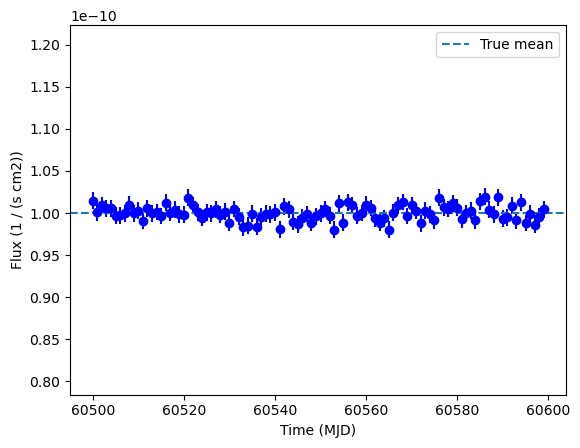

In [4]:
plt.errorbar(x=times.value, y=data.value, yerr=data_err.value,
             fmt='bo')
plt.axhline(mu.value, ls='--', label='True mean')
plt.xlabel('Time (MJD)')
plt.ylabel(f'Flux ({data[0].unit})')
plt.ylim(0.8*np.min(data.value), 1.2*np.max(data.value))
plt.legend()

Let's fit a constant to this time series:

In [5]:
# Fit a constant with curve_fit from scipy
def prior(x, b):
    return 0.*x + b

from scipy import optimize, stats

pars, pars_covariance = optimize.curve_fit(prior, times.value, data.value, [mu.value], sigma=data_err.value)

# And the one-sigma variances in the parameters are:
oneSigmaVariances = np.sqrt(np.diag(pars_covariance))

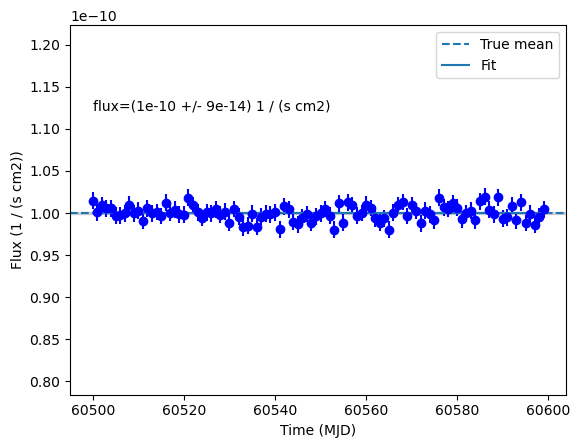

In [6]:
plt.errorbar(x=times.value, y=data.value, yerr=data_err.value,
             fmt='bo')
plt.axhline(mu.value, ls='--', label='True mean')
plt.plot(times.value, prior(times.value, pars[0]), label='Fit')
plt.axhspan(pars[0]-oneSigmaVariances[0],
            pars[0]+oneSigmaVariances[0],
            color="gray",
           alpha=0.3)
plt.xlabel('Time (MJD)')
plt.ylabel(f'Flux ({data[0].unit})')
plt.ylim(0.8*np.min(data.value), 1.2*np.max(data.value))
plt.text(times[0].value, 1.1*np.max(data.value),
         f"flux=({pars[0]:.4g} +/- {oneSigmaVariances[0]:.1g}) {data[0].unit}")
plt.legend()

Let's zoom in:

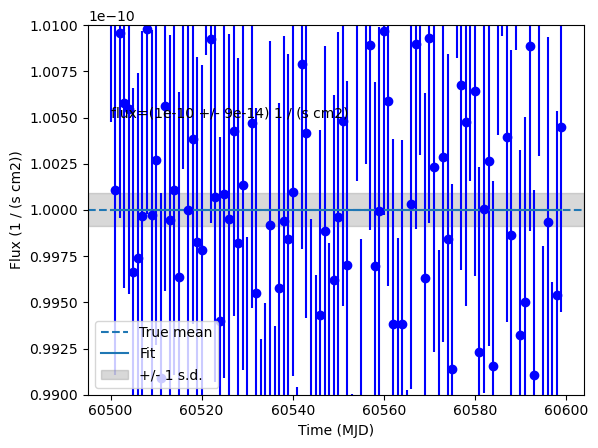

In [7]:
plt.errorbar(x=times.value, y=data.value, yerr=data_err.value,
             fmt='bo')
plt.axhline(mu.value, ls='--', label='True mean')
plt.plot(times.value, prior(times.value, pars[0]), label='Fit')
plt.axhspan(pars[0]-oneSigmaVariances[0],
            pars[0]+oneSigmaVariances[0],
            color="gray",
            alpha=0.3,
            label="+/- 1 s.d.")
plt.xlabel('Time (MJD)')
plt.ylabel(f'Flux ({data[0].unit})')
plt.ylim(0.99*mu.value, 1.01*mu.value)
plt.text(times[0].value, 1.005*mu.value,
         f"flux=({pars[0]:.4g} +/- {oneSigmaVariances[0]:.1g}) {data[0].unit}")
plt.legend()

Let's assess the goodness of fit, (correctly) assuming the data were drawn from a Gaussian distribution:

0.804
  params: FitParams(loc=1e-10, scale=1e-12)
 success: True
 message: 'The fit was performed successfully.'


<Axes: title={'center': 'Fitted $\\tt norm$ PDF and Histogram'}, xlabel='x', ylabel='PDF'>

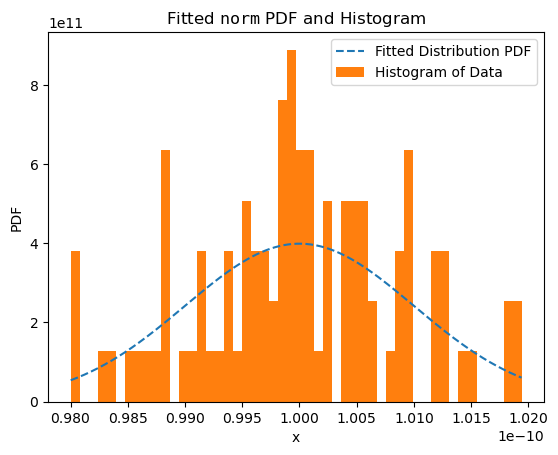

In [8]:
known_params = {'loc': mu.value, 'scale': sigma.value}
res = stats.goodness_of_fit(stats.norm, data.value, known_params=known_params,
                            statistic='ks', random_state=np.random.default_rng())
print(res.pvalue)
print(res.fit_result)
res.fit_result.plot()

The fit result is near enough the injected, true value, though not perfect.

In some situations, especially in the presence of error bars on the x-axis, other fitting methods are better suited.

As an example, instead of `curve_fit`, let's try to use [orthogonal distanceplotgression](https://docs.scipy.org/doc/scipy/reference/odr.html):

In [9]:
# Import the ODR optimization code from scipy.
from scipy.odr import ODR, Model, RealData

# Define a function that we will fit to the data. The function
# arguments are in the opposite order to scipy.optimize.curve_fit
def func(parameters, x):
    b = parameters
    return 0.*x + b

# Create the ODR model.
model = Model(func)

# Process the data and standard deviations into a form used by ODR.
odr_data = RealData(times.value, data.value, sy=data_err.value)

# Let ODR know everything it needs to know. [mu.value] is an initial guess
# of the line parameters.
odr = ODR(odr_data, model, beta0 = [mu.value])

# Run the fit!
output = odr.run()

# Print the output.
output.pprint()

Beta: [1.00000806e-10]
Beta Std Error: [8.92309069e-14]
Beta Covariance: [[1.e-26]]
Residual Variance: 0.7962154742193415
Inverse Condition #: 1.0
Reason(s) for Halting:
  Both sum of squares and parameter convergence


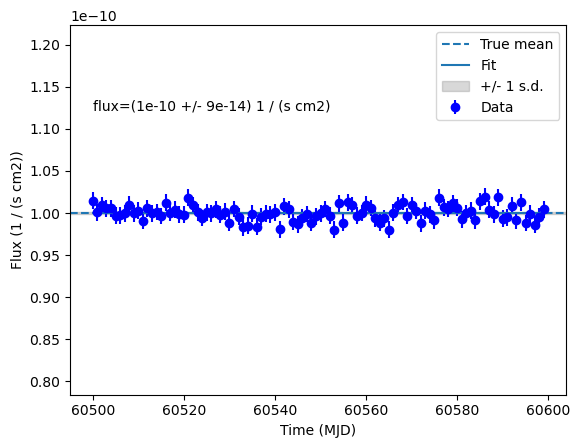

In [10]:
plt.errorbar(x=times.value, y=data.value, yerr=data_err.value,
             fmt='bo',
             label='Data',
            )
plt.axhline(mu.value, ls='--', label='True mean')
plt.plot(times.value, func(output.beta, times.value), label='Fit')
plt.axhspan(output.beta[0]-output.sd_beta[0],
            output.beta[0]+output.sd_beta[0],
            color="gray",
            alpha=0.3,
            label="+/- 1 s.d.")
plt.xlabel('Time (MJD)')
plt.ylabel(f'Flux ({data[0].unit})')
plt.ylim(0.8*np.min(data.value), 1.2*np.max(data.value))
plt.text(times[0].value, 1.1*np.max(data.value),
         f"flux=({output.beta[0]:.4g} +/- {output.sd_beta[0]:.1g}) {data[0].unit}")
plt.legend()

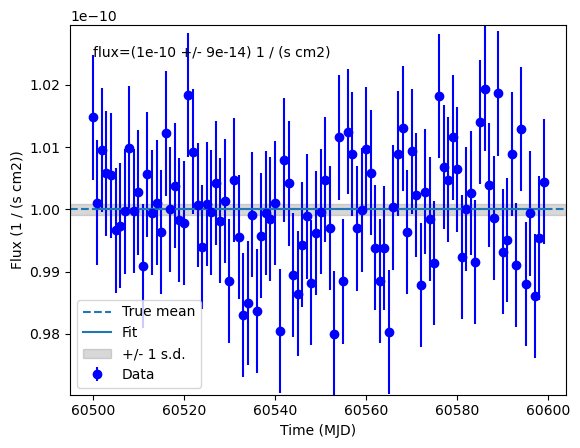

In [11]:
plt.errorbar(x=times.value, y=data.value, yerr=data_err.value,
             fmt='bo',
             label='Data',
            )
plt.axhline(mu.value, ls='--', label='True mean')
plt.plot(times.value, func(output.beta, times.value), label='Fit')
plt.axhspan(output.beta[0]-output.sd_beta[0],
            output.beta[0]+output.sd_beta[0],
            color="gray",
            alpha=0.3,
            label="+/- 1 s.d.")
plt.xlabel('Time (MJD)')
plt.ylabel(f'Flux ({data[0].unit})')
plt.ylim(0.99*np.min(data.value), 1.01*np.max(data.value))
plt.text(times[0].value, 1.005*np.max(data.value),
         f"flux=({output.beta[0]:.4g} +/- {output.sd_beta[0]:.1g}) {data[0].unit}")
plt.legend()

In this case, the resulting fit parameters are identical to the results obtained with `curve_fit`.

# What if the light curve contains upper limits?

![](figures/patatra.png)

In [12]:
# Add upper limits
import random

uplims = np.zeros(times.shape)
list_uplims = np.random.choice(np.arange(len(times)), size=int(0.3*len(times)))
uplims[[list_uplims]] = True

In [13]:
# data[[list_uplims]] *= 1.2

/tmp/ipykernel_55113/389444995.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


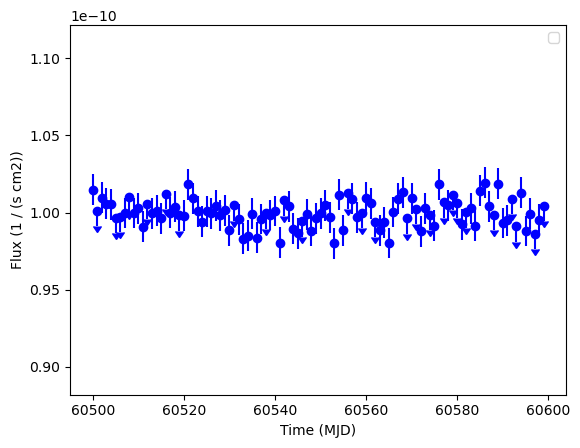

In [14]:
plt.errorbar(x=times.value, y=data.value, yerr=data_err.value,
             uplims=uplims,
             fmt='bo')
plt.xlabel('Time (MJD)')
plt.ylabel(f'Flux ({data[0].unit})')
plt.ylim(0.9*np.min(data.value), 1.1*np.max(data.value))
plt.legend()

Let's use survival analysis, i.e. data censorship, in such a case (see also https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html)

In [15]:
# Prepare the data for scikit-survival

data_y = np.zeros(data.shape, dtype=[("UL", "?"), ("Flux", np.float32)])
data_y["UL"] = uplims
data_y["Flux"] = data
#print(data_y)

data_x = Table()
data_x["Time"] = times.mjd
data_x = data_x.to_pandas()
#print(data_x)

In [16]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x, data_y)
score = estimator.score(data_x, data_y)
print(score)

0.570298769771529


Text(0.5, 0, 'flux ')

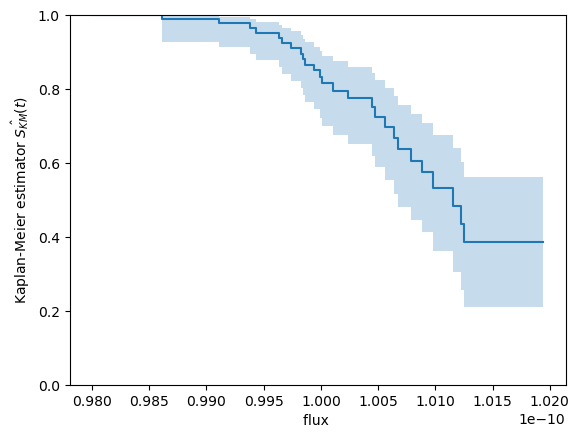

In [17]:
from sksurv.nonparametric import kaplan_meier_estimator

flux, survival_prob, conf_int = kaplan_meier_estimator(
    data_y["UL"], data_y["Flux"], conf_type="log-log"
)
plt.step(flux, survival_prob, where="post")
plt.fill_between(flux, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"Kaplan-Meier estimator $\hat{S_{KM}}(t)$")
plt.xlabel("flux ")

From https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html#Survival-Data:

> The interpretation is identical to the traditional area under the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) metric for binary classification: - a value of 0.5 denotes a random model, - a value of 1.0 denotes a perfect model, - a value of 0.0 denotes a perfectly wrong model.

Here, we want to assess whether our light curve derives from a random fluctuation (constant flux within erros).

### Unevenly binned data

In [18]:
remove = np.random.choice(np.arange(len(times)), size=int(0.8*len(times)))
tmp_data = np.delete(data.value, remove)
tmp_err = np.delete(data_err.value, remove)
tmp_times = np.delete(times.value, remove)
    
times = Time(list(tmp_times), format='mjd', scale='utc')
data = tmp_data * mu.unit
data_err = tmp_err * mu.unit

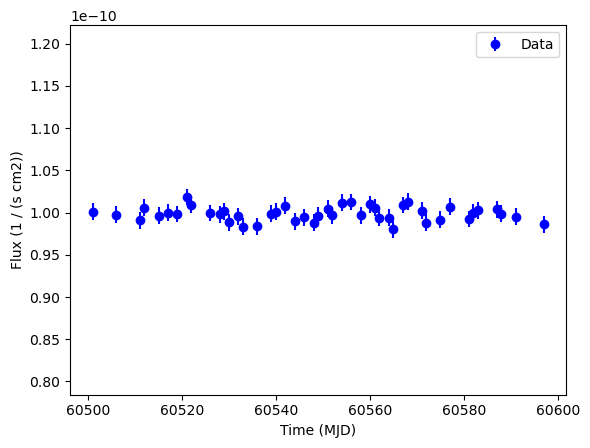

In [19]:
plt.errorbar(x=times.value, y=data.value, yerr=data_err.value,
             uplims=uplims,
             fmt='bo',
             label='Data',
            )
plt.xlabel('Time (MJD)')
plt.ylabel(f'Flux ({data[0].unit})')
plt.ylim(0.8*np.min(data.value), 1.2*np.max(data.value))
plt.legend()


# Power spectral density, fractional variablity, normalized excess variance

> The PSD defines the amount of variability ‘power’ as a function of
temporal frequency.
([Vaughan et al. (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.345.1271V/abstract))

The PSD is linked to the variance of the light curve:

$$\left<S^2\right> = \int_{f_1}^{f_2} P(f) df$$

For an evenly sampled light curve, with sampling period $\delta t$,

$$ P(f_i) = \frac{2 \delta t}{N} |\mathrm{DFT}(f_i)|^2$$

Excess variance:

$$\sigma^2_\mathrm{XS} = S^2 - \overline{\sigma^2_\mathrm{err}}$$

where:

$$\overline{\sigma^2_\mathrm{err}}=\frac{1}{N} \sum_{i=1}^{N} \sigma^2_{\mathrm{err}, i}$$

Normalized excess variance:

$$\sigma^2_\mathrm{NXS} =  \sigma^2_\mathrm{XS}/F_\mathrm{avg}^2$$

and fractional variability:

$$F_\mathrm{var} := \sigma_\mathrm{NXS} = \sqrt{\sigma^2_\mathrm{NXS}} $$

i.e.:

$$F_\mathrm{var} = \sqrt{\frac{1}{F_\mathrm{avg}^2} \left[ \frac{1}{N-1} \sum_{i=1}^{N} \left(F_i - F_\mathrm{avg} \right)^2 - \frac{1}{N} \sum_{i=1}^{N} \sigma^2_{\mathrm{err}, i} \right] }$$
